In [2]:
import json
import pandas as pd

In [3]:
# Load Dataset
df = pd.read_excel('intent-question-cleanned.xlsx')
df.head()

,intent,question
0,Digitall-Installment-Loan,what is digital installment in wing bank
1,Digitall-Installment-Loan,what are feature of wing bank’s digital instal...
2,Digitall-Installment-Loan,what are the fee charges associated with wing ...
3,Digitall-Installment-Loan,how can i check my digital installment eligibi...
4,Digitall-Installment-Loan,what is the minimum purchase amount to use dig...


In [4]:
df.dtypes

intent      object
question    object
dtype: object

In [5]:
df['intent'] = df['intent'].apply(lambda x: str(x) if not isinstance(x, str) else x)
df['question'] = df['question'].apply(lambda x: str(x) if not isinstance(x, str) else x)

In [6]:
# Encode Label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

In [7]:
# Save Label Mapping
label_mapping = dict(zip(df['label'], df['intent']))
with open('label-mapping.json', 'w', encoding='utf-8') as f:
    json.dump(label_mapping, f, ensure_ascii=False)

In [8]:
# Split Data into Train and Test 
from sklearn.model_selection import train_test_split
train_quest, test_quest, train_label, test_label = train_test_split(
    df['question'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [9]:
# Tokenize Data
from transformers import XLMRobertaTokenizer

In [10]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_encoding = tokenizer(train_quest, truncation=True, padding=True, max_length=64, return_tensor='pt')
label_encoding = tokenizer(test_quest, truncation=True, padding=True, max_length=64, return_tensor='pt')

Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword arguments {'return_tensor': 'pt'} not recognized.
Keyword argume

In [11]:
#Create Custom Dataset Class
from torch.utils.data import Dataset
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [12]:
#Create Datasets
import torch
train_dataset = IntentDataset(train_encoding, train_label)
test_dataset = IntentDataset(label_encoding, test_label)

In [13]:
# Load Pre-Trained Model XLM-Roberta-Base
from transformers import XLMRobertaForSequenceClassification, Trainer, TrainingArguments

In [14]:
num_labels = len(df["intent"].unique())
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=num_labels)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import evaluate
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1-score": f1["f1"]
    }

In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=25,
    learning_rate=3e-5,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1-score",
    greater_is_better=True
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Update Trainer to include compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  
)

In [18]:
# Train again
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,3.334400,3.149909,0.150685,0.070672,0.150685,0.078688
2,3.015600,2.709610,0.397260,0.384187,0.397260,0.340683
3,2.301100,2.031221,0.589041,0.452957,0.589041,0.494094
4,1.837000,1.432538,0.890411,0.913079,0.890411,0.873682
5,1.472700,1.111507,0.849315,0.791313,0.849315,0.808298
6,1.035300,0.817151,0.945205,0.934768,0.945205,0.934347
7,0.842300,0.642354,0.917808,0.882801,0.917808,0.893317
8,0.650300,0.537028,0.931507,0.928653,0.931507,0.917628
9,0.478300,0.414252,0.945205,0.929224,0.945205,0.934057
10,0.381700,0.337014,0.958904,0.944064,0.958904,0.948111


TrainOutput(global_step=925, training_loss=0.7041326147156792, metrics={'train_runtime': 396.3457, 'train_samples_per_second': 18.355, 'train_steps_per_second': 2.334, 'total_flos': 97223881189500.0, 'train_loss': 0.7041326147156792, 'epoch': 25.0})

In [19]:
# model.save_pretrained("./Model")
# tokenizer.save_pretrained("./Model")

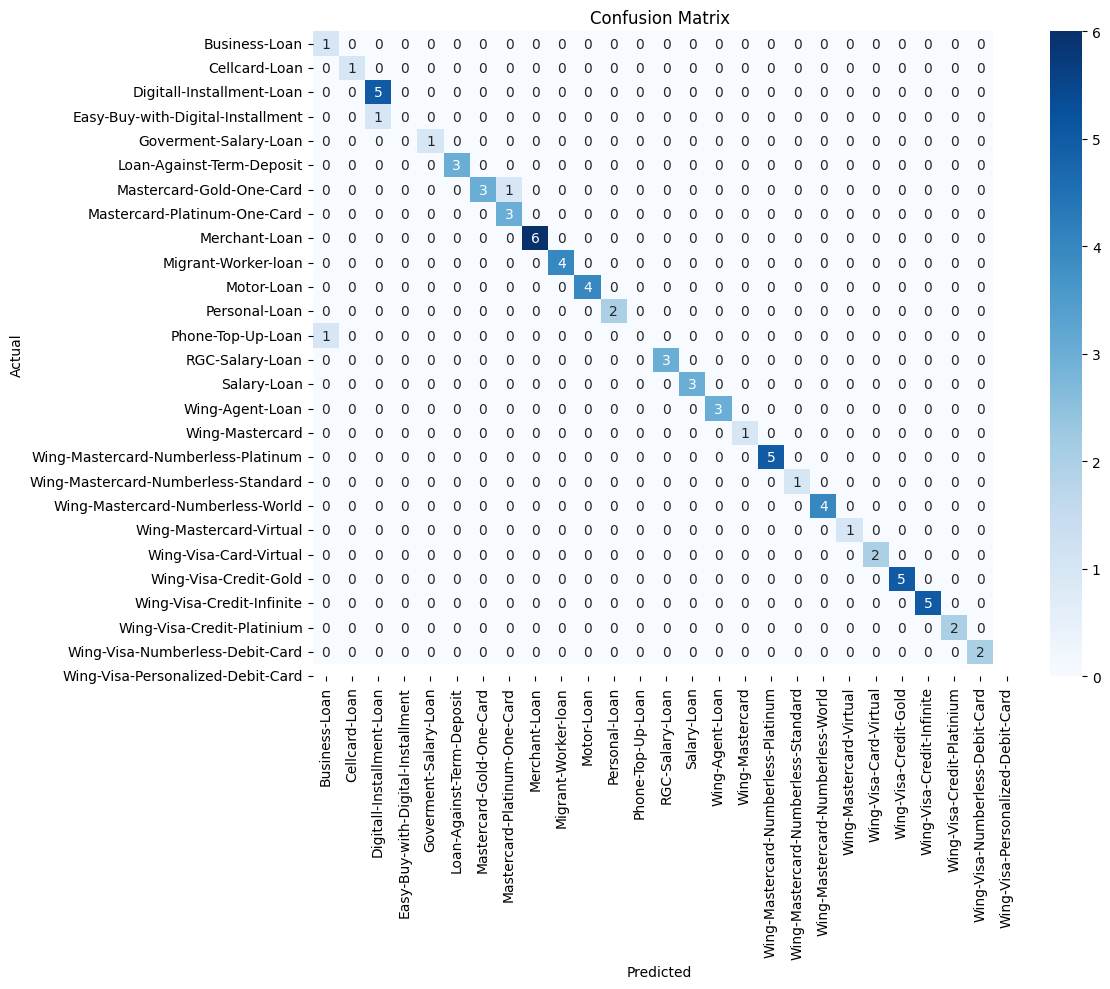

In [22]:
# Confusion Metric
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the test dataset
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
y_pred = np.argmax(logits, axis=1)
y_true = np.array(test_label)

# 2. Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Optional: get readable labels from your label_mapping
with open('label-mapping.json', 'r', encoding='utf-8') as f:
    label_mapping = json.load(f)

# Convert string keys to int
label_mapping = {int(k): v for k, v in label_mapping.items()}
labels = [label_mapping[i] for i in range(len(label_mapping))]

# 4. Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


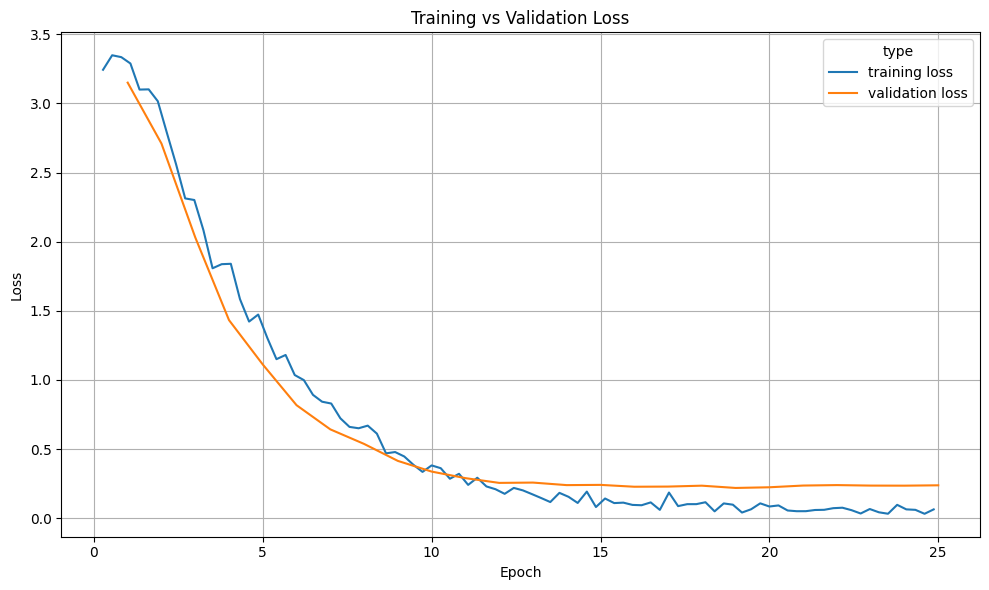

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert log history to DataFrame
logs = trainer.state.log_history

# Extract only entries with loss and eval_loss
loss_data = []

for log in logs:
    if "loss" in log and "epoch" in log:
        loss_data.append({"epoch": log["epoch"], "loss": log["loss"], "type": "training loss"})
    if "eval_loss" in log and "epoch" in log:
        loss_data.append({"epoch": log["epoch"], "loss": log["eval_loss"], "type": "validation loss"})

loss_df = pd.DataFrame(loss_data)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=loss_df, x="epoch", y="loss", hue="type")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
